# Keras and TensorFlow noisy linear model fit with LFI and MCMC

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm

We're going to generate data from a model $f(x)=mx+c+\epsilon$ where $m\sim U(0, 10)$, $c\sim(-2, 2)$ and $\epsilon\sim\mathcal{N}(0, 1)$.

This function generates the data on a regular grid and returns the data and the value of $m$ and $c$ which was used to generate the data.

In [2]:
def data_generator(x, number=100):
    m = np.random.uniform(0, 10)
    c = np.random.uniform(-2, 2)
    ϵ = np.random.normal(0, 1, number)
    return (m * np.linspace(0, 10, number) + c + ϵ).astype(np.float32), m, c

For $x\in[0, 10]$, we make 2000 realisations of the data for random values of $m$ and $c$ and collect the data and the parameter for training and validation. Be a bit careful with the typing (make your data 32 bit floats or state that keras is going to use 64 floats).

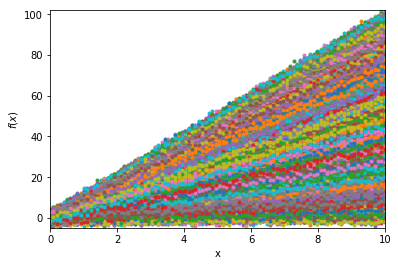

In [3]:
x = np.linspace(0, 10, 100)

parameters = np.zeros((2000, 2)).astype(np.float32)

y = np.zeros((2000, 100)).astype(np.float32)

for i in tqdm.tnrange(2000):
    y_, m_, c_ = data_generator(x)
    parameters[i, 0] = m_
    parameters[i, 1] = c_
    y[i] = y_

plt.plot(x, y.T, '.')
plt.xlabel("x")
plt.ylabel("$f(x)$")
plt.xlim([0, 10])
plt.ylim([y.min(), y.max()]);

Lets say we observe some data from this model

The data has a true m = 1.0998862554461042 and c = -1.7751232589636916


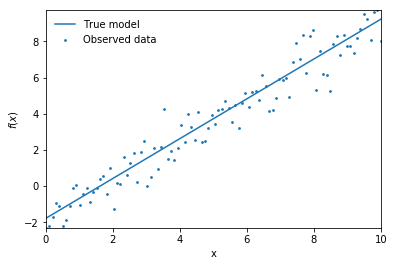

In [4]:
y_observed, m_observed, c_observed = data_generator(x)
print("The data has a true m = " + str(m_observed) + " and c = " + str(c_observed))
plt.scatter(x, y_observed, s=3, label="Observed data")
plt.plot(x, m_observed * x + c_observed, label="True model")
plt.xlabel("x")
plt.ylabel("$f(x)$")
plt.xlim([0, 10])
plt.ylim([y_observed.min(), y_observed.max()])
plt.legend(frameon=False);

# Keras

In keras (within TensorFlow) we make a fully connected neural model with two-hidden layers (with 16 nodes in each layer), activated with LeakyReLU ($\max[x, \alpha x]$), which takes in the 100 element data vector and has two outputs which we will regress to the $m$ and $c$ for the data. This network has 1,922 tunable parameters in total.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(100),
    tf.keras.layers.Dense(16),
    tf.keras.layers.LeakyReLU(0.01),
    tf.keras.layers.Dense(16),
    tf.keras.layers.LeakyReLU(0.01),
    tf.keras.layers.Dense(2),
    tf.keras.layers.LeakyReLU(0.01),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2)                 0         
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
______________________________________________________

We are going to minimise the mean square error $\Lambda = \frac{1}{N}\sum_{i}^N(\textrm{model}(y_i) - f(x_i))^2$ using an Adam optimiser (a stochastic gradient descent with a bunch of optimisations such as accumulated gradients).

In [6]:
model.compile(optimizer="adam", loss="mse")

We can now fit the parameter on the model. We are going to use 1000 data-parameter pairs to update the weights and then validate on another 1000 seperate data-parameter pairs. We will make 2500 entire passes through the data with batches of 128 data-parameter pairs at in the average.

In [7]:
model.fit(x=y[:1000], 
          y=parameters[:1000], 
          validation_data=(y[1000:], parameters[1000:]), 
          epochs=2500,
          batch_size=128)

Train on 1000 samples, validate on 1000 samples
Epoch 1/2500
1000/1000 [==============================] - 1s 708us/sample - loss: 15.7386 - val_loss: 5.5549
Epoch 2/2500
1000/1000 [==============================] - 0s 37us/sample - loss: 2.8408 - val_loss: 2.5956
Epoch 3/2500
1000/1000 [==============================] - 0s 59us/sample - loss: 1.6855 - val_loss: 1.7789
Epoch 4/2500
1000/1000 [==============================] - 0s 75us/sample - loss: 1.3363 - val_loss: 1.1824
Epoch 5/2500
1000/1000 [==============================] - 0s 71us/sample - loss: 1.1885 - val_loss: 1.0389
Epoch 6/2500
1000/1000 [==============================] - 0s 53us/sample - loss: 1.1043 - val_loss: 1.0494
Epoch 7/2500
1000/1000 [==============================] - 0s 64us/sample - loss: 1.0663 - val_loss: 0.9955
Epoch 8/2500
1000/1000 [==============================] - 0s 78us/sample - loss: 1.0474 - val_loss: 0.9926
Epoch 9/2500
1000/1000 [==============================] - 0s 76us/sample - loss: 1.0306 - val_

1000/1000 [==============================] - 0s 30us/sample - loss: 0.4694 - val_loss: 0.4977
Epoch 152/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.4799 - val_loss: 0.4906
Epoch 153/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.4944 - val_loss: 0.5054
Epoch 154/2500
1000/1000 [==============================] - 0s 28us/sample - loss: 0.4691 - val_loss: 0.4874
Epoch 155/2500
1000/1000 [==============================] - 0s 28us/sample - loss: 0.4677 - val_loss: 0.4997
Epoch 156/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.4693 - val_loss: 0.4885
Epoch 157/2500
1000/1000 [==============================] - 0s 33us/sample - loss: 0.4715 - val_loss: 0.4825
Epoch 158/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.4695 - val_loss: 0.4856
Epoch 159/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.4679 - val_loss: 0.4914
Epoch 160/2500
1000/1000 [========

1000/1000 [==============================] - 0s 43us/sample - loss: 0.3885 - val_loss: 0.4134
Epoch 302/2500
1000/1000 [==============================] - 0s 41us/sample - loss: 0.3956 - val_loss: 0.4167
Epoch 303/2500
1000/1000 [==============================] - 0s 40us/sample - loss: 0.4030 - val_loss: 0.4335
Epoch 304/2500
1000/1000 [==============================] - 0s 40us/sample - loss: 0.3994 - val_loss: 0.4070
Epoch 305/2500
1000/1000 [==============================] - 0s 45us/sample - loss: 0.3895 - val_loss: 0.4065
Epoch 306/2500
1000/1000 [==============================] - 0s 41us/sample - loss: 0.3959 - val_loss: 0.4259
Epoch 307/2500
1000/1000 [==============================] - 0s 38us/sample - loss: 0.3968 - val_loss: 0.4065
Epoch 308/2500
1000/1000 [==============================] - 0s 41us/sample - loss: 0.4026 - val_loss: 0.4104
Epoch 309/2500
1000/1000 [==============================] - 0s 40us/sample - loss: 0.3914 - val_loss: 0.4100
Epoch 310/2500
1000/1000 [========

1000/1000 [==============================] - 0s 57us/sample - loss: 0.0880 - val_loss: 0.1132
Epoch 452/2500
1000/1000 [==============================] - 0s 39us/sample - loss: 0.0903 - val_loss: 0.1236
Epoch 453/2500
1000/1000 [==============================] - 0s 36us/sample - loss: 0.0956 - val_loss: 0.1113
Epoch 454/2500
1000/1000 [==============================] - 0s 37us/sample - loss: 0.0963 - val_loss: 0.1103
Epoch 455/2500
1000/1000 [==============================] - 0s 41us/sample - loss: 0.0952 - val_loss: 0.1204
Epoch 456/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.1021 - val_loss: 0.1200
Epoch 457/2500
1000/1000 [==============================] - 0s 35us/sample - loss: 0.0908 - val_loss: 0.0996
Epoch 458/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0796 - val_loss: 0.0983
Epoch 459/2500
1000/1000 [==============================] - 0s 37us/sample - loss: 0.0792 - val_loss: 0.0987
Epoch 460/2500
1000/1000 [========

1000/1000 [==============================] - 0s 46us/sample - loss: 0.0597 - val_loss: 0.0769
Epoch 527/2500
1000/1000 [==============================] - 0s 41us/sample - loss: 0.0538 - val_loss: 0.0717
Epoch 528/2500
1000/1000 [==============================] - 0s 33us/sample - loss: 0.0519 - val_loss: 0.0740
Epoch 529/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0546 - val_loss: 0.0740
Epoch 530/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0575 - val_loss: 0.0784
Epoch 531/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0566 - val_loss: 0.0746
Epoch 532/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0536 - val_loss: 0.0766
Epoch 533/2500
1000/1000 [==============================] - 0s 39us/sample - loss: 0.0530 - val_loss: 0.0734
Epoch 534/2500
1000/1000 [==============================] - 0s 42us/sample - loss: 0.0553 - val_loss: 0.0821
Epoch 535/2500
1000/1000 [========

1000/1000 [==============================] - 0s 35us/sample - loss: 0.0474 - val_loss: 0.0571
Epoch 677/2500
1000/1000 [==============================] - 0s 33us/sample - loss: 0.0435 - val_loss: 0.0587
Epoch 678/2500
1000/1000 [==============================] - 0s 43us/sample - loss: 0.0415 - val_loss: 0.0592
Epoch 679/2500
1000/1000 [==============================] - 0s 38us/sample - loss: 0.0404 - val_loss: 0.0569
Epoch 680/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0414 - val_loss: 0.0606
Epoch 681/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0398 - val_loss: 0.0566
Epoch 682/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0418 - val_loss: 0.0614
Epoch 683/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0392 - val_loss: 0.0589
Epoch 684/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0383 - val_loss: 0.0554
Epoch 685/2500
1000/1000 [========

1000/1000 [==============================] - 0s 29us/sample - loss: 0.0359 - val_loss: 0.0485
Epoch 827/2500
1000/1000 [==============================] - 0s 39us/sample - loss: 0.0329 - val_loss: 0.0518
Epoch 828/2500
1000/1000 [==============================] - 0s 33us/sample - loss: 0.0342 - val_loss: 0.0506
Epoch 829/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0372 - val_loss: 0.0547
Epoch 830/2500
1000/1000 [==============================] - 0s 39us/sample - loss: 0.0333 - val_loss: 0.0501
Epoch 831/2500
1000/1000 [==============================] - 0s 33us/sample - loss: 0.0356 - val_loss: 0.0524
Epoch 832/2500
1000/1000 [==============================] - 0s 35us/sample - loss: 0.0336 - val_loss: 0.0530
Epoch 833/2500
1000/1000 [==============================] - 0s 35us/sample - loss: 0.0363 - val_loss: 0.0671
Epoch 834/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0489 - val_loss: 0.0543
Epoch 835/2500
1000/1000 [========

1000/1000 [==============================] - 0s 33us/sample - loss: 0.0366 - val_loss: 0.0536
Epoch 977/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0374 - val_loss: 0.0576
Epoch 978/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0375 - val_loss: 0.0478
Epoch 979/2500
1000/1000 [==============================] - 0s 43us/sample - loss: 0.0418 - val_loss: 0.0476
Epoch 980/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0333 - val_loss: 0.0515
Epoch 981/2500
1000/1000 [==============================] - 0s 33us/sample - loss: 0.0319 - val_loss: 0.0498
Epoch 982/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0286 - val_loss: 0.0492
Epoch 983/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0286 - val_loss: 0.0449
Epoch 984/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0274 - val_loss: 0.0487
Epoch 985/2500
1000/1000 [========

Epoch 1051/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0387 - val_loss: 0.0890
Epoch 1052/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0518 - val_loss: 0.0558
Epoch 1053/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0329 - val_loss: 0.0532
Epoch 1054/2500
1000/1000 [==============================] - 0s 41us/sample - loss: 0.0296 - val_loss: 0.0498
Epoch 1055/2500
1000/1000 [==============================] - 0s 40us/sample - loss: 0.0411 - val_loss: 0.0646
Epoch 1056/2500
1000/1000 [==============================] - 0s 39us/sample - loss: 0.0432 - val_loss: 0.0579
Epoch 1057/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0316 - val_loss: 0.0459
Epoch 1058/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0270 - val_loss: 0.0421
Epoch 1059/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0251 - val_loss: 0.0418
Epoch 1060

1000/1000 [==============================] - 0s 42us/sample - loss: 0.0235 - val_loss: 0.0456
Epoch 1200/2500
1000/1000 [==============================] - 0s 33us/sample - loss: 0.0248 - val_loss: 0.0390
Epoch 1201/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0222 - val_loss: 0.0415
Epoch 1202/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0236 - val_loss: 0.0383
Epoch 1203/2500
1000/1000 [==============================] - 0s 33us/sample - loss: 0.0219 - val_loss: 0.0385
Epoch 1204/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0244 - val_loss: 0.0435
Epoch 1205/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0246 - val_loss: 0.0422
Epoch 1206/2500
1000/1000 [==============================] - 0s 47us/sample - loss: 0.0256 - val_loss: 0.0418
Epoch 1207/2500
1000/1000 [==============================] - 0s 51us/sample - loss: 0.0246 - val_loss: 0.0400
Epoch 1208/2500
1000/1000 

1000/1000 [==============================] - 0s 33us/sample - loss: 0.0222 - val_loss: 0.0400
Epoch 1348/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0218 - val_loss: 0.0371
Epoch 1349/2500
1000/1000 [==============================] - 0s 39us/sample - loss: 0.0216 - val_loss: 0.0401
Epoch 1350/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0225 - val_loss: 0.0398
Epoch 1351/2500
1000/1000 [==============================] - 0s 37us/sample - loss: 0.0221 - val_loss: 0.0406
Epoch 1352/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0236 - val_loss: 0.0383
Epoch 1353/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0234 - val_loss: 0.0422
Epoch 1354/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0249 - val_loss: 0.0445
Epoch 1355/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0243 - val_loss: 0.0369
Epoch 1356/2500
1000/1000 

1000/1000 [==============================] - 0s 35us/sample - loss: 0.0238 - val_loss: 0.0402
Epoch 1496/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0230 - val_loss: 0.0358
Epoch 1497/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0203 - val_loss: 0.0414
Epoch 1498/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0228 - val_loss: 0.0344
Epoch 1499/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0208 - val_loss: 0.0349
Epoch 1500/2500
1000/1000 [==============================] - 0s 39us/sample - loss: 0.0223 - val_loss: 0.0398
Epoch 1501/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0247 - val_loss: 0.0387
Epoch 1502/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0225 - val_loss: 0.0412
Epoch 1503/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0219 - val_loss: 0.0369
Epoch 1504/2500
1000/1000 

1000/1000 [==============================] - 0s 31us/sample - loss: 0.0344 - val_loss: 0.0577
Epoch 1644/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0481 - val_loss: 0.0535
Epoch 1645/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0387 - val_loss: 0.0360
Epoch 1646/2500
1000/1000 [==============================] - 0s 28us/sample - loss: 0.0235 - val_loss: 0.0342
Epoch 1647/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0215 - val_loss: 0.0361
Epoch 1648/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0244 - val_loss: 0.0471
Epoch 1649/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0272 - val_loss: 0.0348
Epoch 1650/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0205 - val_loss: 0.0336
Epoch 1651/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0196 - val_loss: 0.0346
Epoch 1652/2500
1000/1000 

1000/1000 [==============================] - 0s 33us/sample - loss: 0.0198 - val_loss: 0.0342
Epoch 1792/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0195 - val_loss: 0.0335
Epoch 1793/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0193 - val_loss: 0.0348
Epoch 1794/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0237 - val_loss: 0.0436
Epoch 1795/2500
1000/1000 [==============================] - 0s 28us/sample - loss: 0.0246 - val_loss: 0.0415
Epoch 1796/2500
1000/1000 [==============================] - 0s 28us/sample - loss: 0.0221 - val_loss: 0.0352
Epoch 1797/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0203 - val_loss: 0.0363
Epoch 1798/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0202 - val_loss: 0.0346
Epoch 1799/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0203 - val_loss: 0.0339
Epoch 1800/2500
1000/1000 

1000/1000 [==============================] - 0s 30us/sample - loss: 0.0200 - val_loss: 0.0329
Epoch 1940/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0182 - val_loss: 0.0337
Epoch 1941/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0183 - val_loss: 0.0341
Epoch 1942/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0181 - val_loss: 0.0336
Epoch 1943/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0204 - val_loss: 0.0352
Epoch 1944/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0213 - val_loss: 0.0358
Epoch 1945/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0236 - val_loss: 0.0349
Epoch 1946/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0245 - val_loss: 0.0404
Epoch 1947/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0231 - val_loss: 0.0346
Epoch 1948/2500
1000/1000 

1000/1000 [==============================] - 0s 46us/sample - loss: 0.0217 - val_loss: 0.0337
Epoch 2088/2500
1000/1000 [==============================] - 0s 37us/sample - loss: 0.0174 - val_loss: 0.0342
Epoch 2089/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0170 - val_loss: 0.0334
Epoch 2090/2500
1000/1000 [==============================] - ETA: 0s - loss: 0.017 - 0s 33us/sample - loss: 0.0178 - val_loss: 0.0335
Epoch 2091/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0169 - val_loss: 0.0340
Epoch 2092/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0172 - val_loss: 0.0354
Epoch 2093/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0193 - val_loss: 0.0480
Epoch 2094/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0250 - val_loss: 0.0351
Epoch 2095/2500
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0203 - val_loss: 0.0336
Ep

1000/1000 [==============================] - 0s 28us/sample - loss: 0.0178 - val_loss: 0.0335
Epoch 2236/2500
1000/1000 [==============================] - 0s 28us/sample - loss: 0.0181 - val_loss: 0.0372
Epoch 2237/2500
1000/1000 [==============================] - 0s 28us/sample - loss: 0.0190 - val_loss: 0.0339
Epoch 2238/2500
1000/1000 [==============================] - 0s 67us/sample - loss: 0.0180 - val_loss: 0.0322
Epoch 2239/2500
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0177 - val_loss: 0.0381
Epoch 2240/2500
1000/1000 [==============================] - 0s 39us/sample - loss: 0.0192 - val_loss: 0.0323
Epoch 2241/2500
1000/1000 [==============================] - 0s 31us/sample - loss: 0.0184 - val_loss: 0.0376
Epoch 2242/2500
1000/1000 [==============================] - 0s 30us/sample - loss: 0.0192 - val_loss: 0.0348
Epoch 2243/2500
1000/1000 [==============================] - 0s 70us/sample - loss: 0.0183 - val_loss: 0.0348
Epoch 2244/2500
1000/1000 

1000/1000 [==============================] - 0s 30us/sample - loss: 0.0258 - val_loss: 0.0393
Epoch 2384/2500
1000/1000 [==============================] - 0s 28us/sample - loss: 0.0218 - val_loss: 0.0316
Epoch 2385/2500
1000/1000 [==============================] - 0s 26us/sample - loss: 0.0196 - val_loss: 0.0321
Epoch 2386/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0172 - val_loss: 0.0332
Epoch 2387/2500
1000/1000 [==============================] - 0s 26us/sample - loss: 0.0174 - val_loss: 0.0321
Epoch 2388/2500
1000/1000 [==============================] - 0s 28us/sample - loss: 0.0180 - val_loss: 0.0315
Epoch 2389/2500
1000/1000 [==============================] - 0s 27us/sample - loss: 0.0170 - val_loss: 0.0317
Epoch 2390/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0166 - val_loss: 0.0320
Epoch 2391/2500
1000/1000 [==============================] - 0s 29us/sample - loss: 0.0165 - val_loss: 0.0316
Epoch 2392/2500
1000/1000 

We can plot the mean square error as a function of epochs

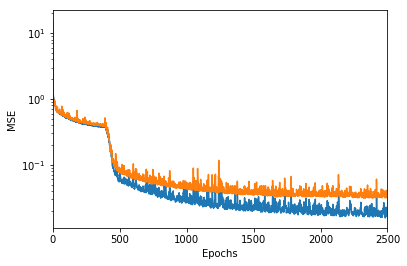

In [8]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.yscale("log")
plt.xlim([0, 2500]);

We can compare the values of $m$ and $c$ for our observed data (created earlier) with our new trained predictor.

The data has a true m = 1.0998862554461042 and c = -1.7751232589636916
The keras model has a predicted m = 1.0012007 and c = -1.7813333


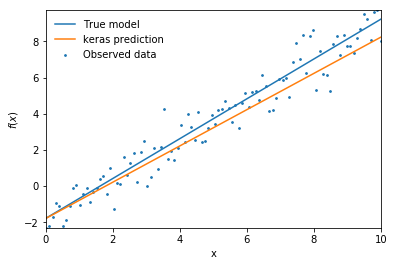

In [9]:
keras_predicted = model.predict(np.array([y_observed]))
plt.scatter(x, y_observed, s=3, label="Observed data")
plt.plot(x, m_observed * x + c_observed, label="True model")
plt.plot(x, keras_predicted[0, 0] * x + keras_predicted[0, 1], label="keras prediction");
plt.xlabel("x")
plt.ylabel("$f(x)$")
plt.xlim([0, 10])
plt.ylim([y_observed.min(), y_observed.max()])
plt.legend(frameon=False);
print("The data has a true m = " + str(m_observed) + " and c = " + str(c_observed))
print("The keras model has a predicted m = " + str(keras_predicted[0, 0]) + " and c = " + str(keras_predicted[0, 1]))

# TensorFlow

We can do the same using TensorFlow (in several ways). The most basic way to do it is to use a keras model as before, but we can really build an optimal loss function (although here we will still use the mean square error).

In this method we can build the model in exactly the same way, but we need to select which optimiser we want to use (we will use the Adam optimiser again).

In [10]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(100),
    tf.keras.layers.Dense(16),
    tf.keras.layers.LeakyReLU(0.01),
    tf.keras.layers.Dense(16),
    tf.keras.layers.LeakyReLU(0.01),
    tf.keras.layers.Dense(2),
    tf.keras.layers.LeakyReLU(0.01),
])
model.summary()
opt = tf.keras.optimizers.Adam()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2)                 0         
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
______________________________________________________

First we need a function which calculates the loss function. This is done with TensorFlow functions which are overloaded for pythonic scripting. Note not everything is overloaded, so I personally prefer to use the defined TensorFlow functions. Using the tf.function decorator makes the function auto-compile into a graph which will be automatically deployed on a GPU is one is available.

In [11]:
@tf.function
def calculate_loss(y, parameters):
    output = model_2(y)
    return tf.reduce_mean(
        tf.square(
            tf.subtract(
                output, 
                parameters))) 

To train the TensorFlow model we need calculate the loss and take the gradient of it with respect to the model_2 variables. Then we can use the optimiser to perform a single weight update step (according to the Adam optimiser). Note that if you decorate this function with `@tf.function` any function which is called within it is automatically auto-graphed, even if that function doesn't have a `@tf.function` decoration. A common stumbling block with the `tf.GradientTape()` is that anything that you want to have the gradient of has to be calculated within the tape - this includes slicing operations and other things you wouldn't expect.

In [12]:
@tf.function
def train(y, parameters):
    with tf.GradientTape() as tape:
        tape.watch(model_2.variables)
        loss = calculate_loss(y, parameters)
    gradients = tape.gradient(loss, model_2.variables)
    opt.apply_gradients(zip(gradients, model_2.variables))
    return loss

In a mindless way, we are going to collect the loss and validation loss in lists at the end of each epoch.

In [13]:
loss = []
val_loss = []

Now we can fit the model. We will do 2500 full passes of the data with weight updates performed on batches of 128 data at a time, with 1000 simulations for training and 1000 for validation.

In [14]:
epochs = 2500
batch_size = 128
training_size = 1000
validation_size = 2000 - training_size

batches = int(training_size / batch_size)
val_batches = int(validation_size / batch_size)

epoch_bar = tqdm.tnrange(epochs, desc="Epochs")
batch_bar = tqdm.tnrange(batches, desc="Batch")

indices = np.arange(training_size, dtype=np.int64)

validation_data = y[training_size: training_size + val_batches * batch_size].reshape(
    (val_batches, batch_size, 100))
validation_parameters = parameters[training_size: training_size + val_batches * batch_size].reshape(
    (val_batches, batch_size, 2))

for epoch in epoch_bar:
    np.random.shuffle(indices)
    training_data = y[indices[:batches * batch_size]].reshape((batches, batch_size, 100))
    training_parameters = parameters[indices[:batches * batch_size]].reshape((batches, batch_size, 2))
    for batch in batch_bar:
        this_loss = train(training_data[batch], training_parameters[batch])
    loss.append(this_loss.numpy())
    this_val_loss = 0.
    for batch in range(val_batches):
        this_val_loss += (calculate_loss(validation_data[batch], validation_parameters[batch]) 
                              / float(val_batches))
    val_loss.append(this_val_loss.numpy())
    epoch_bar.set_postfix(loss=this_loss.numpy(), val_loss=this_val_loss.numpy())

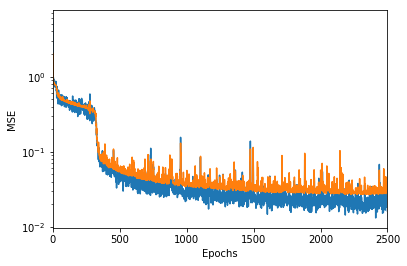

In [15]:
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.yscale("log")
plt.xlim([0, 2500]);

The data has a true m = 1.0998862554461042 and c = -1.7751232589636916
The keras model has a predicted m = 1.0012007 and c = -1.7813333
The TensorFlow model has a predicted m = 1.0289211 and c = -1.7442932


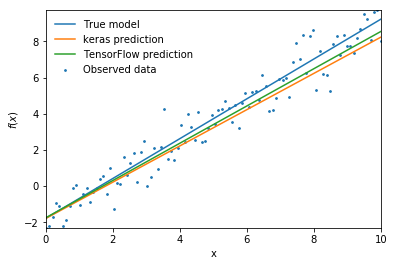

In [16]:
tensorflow_predicted = model_2(np.array([y_observed])).numpy()
plt.scatter(x, y_observed, s=3, label="Observed data")
plt.plot(x, m_observed * x + c_observed, label="True model")
plt.plot(x, keras_predicted[0, 0] * x + keras_predicted[0, 1], label="keras prediction");
plt.plot(x, tensorflow_predicted[0, 0] * x + tensorflow_predicted[0, 1], 
         label="TensorFlow prediction");
plt.xlabel("x")
plt.ylabel("$f(x)$")
plt.xlim([0, 10])
plt.ylim([y_observed.min(), y_observed.max()])
plt.legend(frameon=False);
print("The data has a true m = " + str(m_observed) + " and c = " + str(c_observed))
print("The keras model has a predicted m = " + str(keras_predicted[0, 0]) + " and c = " + str(keras_predicted[0, 1]))
print("The TensorFlow model has a predicted m = " + str(tensorflow_predicted[0, 0]) + " and c = " + str(tensorflow_predicted[0, 1]))

Notice how none of the values are the same - even for the same selection of data, but different initialisation of weights and different shuffling of data... suspicious...

# Likelihood Free Inference 

We can do the first order, most stupid, likelihood-free inference, approximate Bayesian computation (ABC). Here we draw 100000 simulations of the data from the prior distributions of $p(m)=U(0, 10)$ and $p(c)=U(-2, 2)$ and our linear model.

In [17]:
ABC_parameters = np.zeros((100000, 2)).astype(np.float32)
ABC_y = np.zeros((100000, 100)).astype(np.float32)
for i in tqdm.tnrange(100000):
    y_, m_, c_ = data_generator(x)
    ABC_parameters[i, 0] = m_
    ABC_parameters[i, 1] = c_
    ABC_y[i] = y_

Now we calculate the summaries (outputs) of the network for all of this data.

In [18]:
keras_summaries = model(ABC_y).numpy()

tensorflow_summaries = model_2(ABC_y).numpy()

Next we calculate the Euclidean distance between the simulation summaries and the prediction of the observed data. The Euclidean distances is the optimal distance measure for maximum likelihood estimates of the parameter values. The outputs of the network won't be exactly the maximum likelihood estimates, but they'll probably be very close, and so the distances will probably be close. Note that this choice of distance measure is necessary because we're using ABC and not DELFI (density estimation likelihood free inference).

In [20]:
keras_differences = (keras_summaries - keras_predicted)
keras_distances = np.sqrt(np.sum(keras_differences**2., axis=1))

tensorflow_differences = (tensorflow_summaries - tensorflow_predicted)
tensorflow_distances = np.sqrt(np.sum(keras_differences**2., axis=1))

Let's say we want to have 1000 points within our posterior histogram, we can choose some epsilon parameter which selects this quantity.

In [21]:
keras_ϵ = np.sort(keras_distances)[1000]
tensorflow_ϵ = np.sort(tensorflow_distances)[1000]

Our accepted samples are any samples whose distances are less than $\epsilon$ away from the observed data.

In [22]:
keras_accepted = np.where(keras_distances < keras_ϵ)[0]
keras_rejected = np.where(keras_distances >= keras_ϵ)[0]

tensorflow_accepted = np.where(tensorflow_distances < tensorflow_ϵ)[0]
tensorflow_rejected = np.where(tensorflow_distances >= tensorflow_ϵ)[0]

Now we select the parameters which were used to make the simulations which are accepted (which look most like the prediction of the parameters of the observed data).

In [23]:
keras_keep = ABC_parameters[keras_accepted]
keras_throw_away = ABC_parameters[keras_rejected]

tensorflow_keep = ABC_parameters[tensorflow_accepted]
tensorflow_throw_away = ABC_parameters[tensorflow_rejected]

Now we can look at which samples are accepted

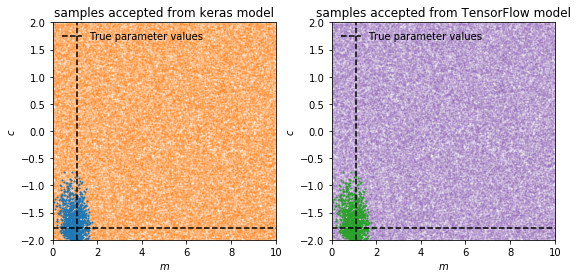

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
plt.subplots_adjust(wspace=0.25)
ax[0].scatter(keras_throw_away[:, 0], keras_throw_away[:, 1], s=1, color="C1", alpha=0.1)
ax[0].scatter(keras_keep[:, 0], keras_keep[:, 1], s=1, color="C0")
ax[0].set_xlim([0, 10])
ax[0].set_ylim([-2, 2])
ax[0].axvline(m_observed, color="black", linestyle="dashed", label="True parameter values")
ax[0].axhline(c_observed, color="black", linestyle="dashed")
ax[0].set_xlabel("$m$")
ax[0].set_ylabel("$c$")
ax[0].set_title("samples accepted from keras model")
ax[0].legend(loc=2, frameon=False)

ax[1].scatter(tensorflow_throw_away[:, 0], tensorflow_throw_away[:, 1], s=1, color="C4", alpha=0.1)
ax[1].scatter(tensorflow_keep[:, 0], tensorflow_keep[:, 1], s=1, color="C2")
ax[1].set_xlim([0, 10])
ax[1].set_ylim([-2, 2])
ax[1].axvline(m_observed, color="black", linestyle="dashed", label="True parameter values")
ax[1].axhline(c_observed, color="black", linestyle="dashed")
ax[1].set_xlabel("$m$")
ax[1].set_ylabel("$c$")
ax[1].set_title("samples accepted from TensorFlow model")
ax[1].legend(loc=2, frameon=False);

We can also plot the outputs of the network which might be indicative of biases (or maybe not)

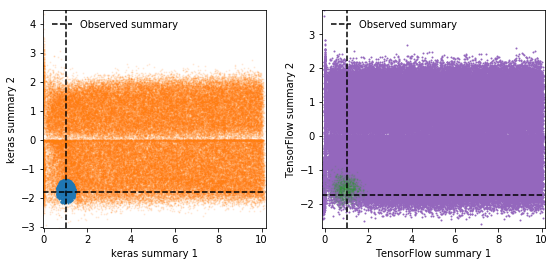

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
plt.subplots_adjust(wspace=0.25)
ax[0].scatter(keras_summaries[keras_rejected, 0], keras_summaries[keras_rejected, 1], s=1, color="C1", alpha=0.1)
ax[0].scatter(keras_summaries[keras_accepted, 0], keras_summaries[keras_accepted, 1], s=1, color="C0")
ax[0].set_xlim([np.min(keras_summaries[:, 0]), np.max(keras_summaries[:, 0])])
ax[0].set_ylim([np.min(keras_summaries[:, 1]), np.max(keras_summaries[:, 1])])
ax[0].axhline(keras_predicted[0, 1], color="black", linestyle="dashed", label="Observed summary")
ax[0].axvline(keras_predicted[0, 0], color="black", linestyle="dashed")
ax[0].set_xlabel("keras summary 1")
ax[0].set_ylabel("keras summary 2")
ax[0].legend(loc=2, frameon=False)

ax[1].scatter(tensorflow_summaries[tensorflow_rejected, 0], tensorflow_summaries[tensorflow_rejected, 1], s=1, color="C4")
ax[1].scatter(tensorflow_summaries[tensorflow_accepted, 0], tensorflow_summaries[tensorflow_accepted, 1], s=1, color="C2", alpha=0.1)
ax[1].set_xlim([np.min(tensorflow_summaries[:, 0]), np.max(tensorflow_summaries[:, 0])])
ax[1].set_ylim([np.min(tensorflow_summaries[:, 1]), np.max(tensorflow_summaries[:, 1])])
ax[1].axhline(tensorflow_predicted[0, 1], color="black", linestyle="dashed", label="Observed summary")
ax[1].axvline(tensorflow_predicted[0, 0], color="black", linestyle="dashed")
ax[1].set_xlabel("TensorFlow summary 1")
ax[1].set_ylabel("TensorFlow summary 2")
ax[1].legend(loc=2, frameon=False);

And the inference can be done with histograms of the accepted samples for the keras and Tensorflow predictions

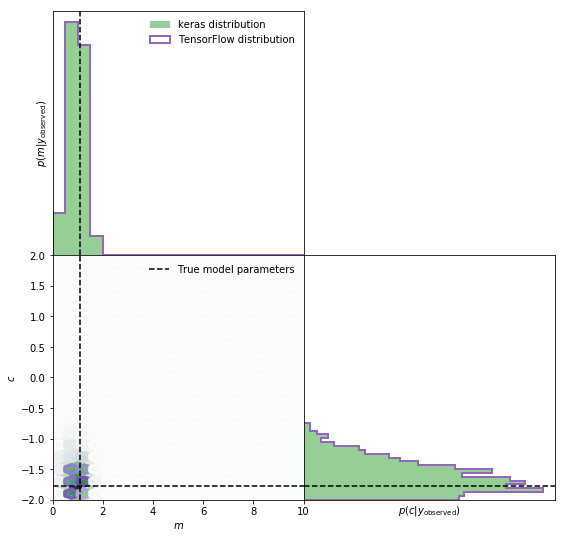

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
plt.subplots_adjust(wspace=0,hspace=0)
ax[0, 0].hist(keras_keep[:, 0], 
              bins=20, 
              range=[0, 10], 
              density=True, 
              color="C2", 
              alpha=0.5,
              label="keras distribution")
ax[0, 0].hist(tensorflow_keep[:, 0],
              bins=20, 
              range=[0, 10], 
              density=True, 
              color="C4", 
              linewidth=2, 
              histtype="step",
              label="TensorFlow distribution")
ax[0, 0].legend(frameon=False)
ax[0, 0].set_ylabel("$p(m|y_{\\rm observed})$")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 0].set_xlim([0, 10])
ax[0, 0].axvline(m_observed, 
                 color="black", 
                 linestyle="dashed")
ax[1, 0].hexbin(keras_keep[:, 0], 
                keras_keep[:, 1], 
                gridsize=(20, 20), 
                extent=(0, 10, -2, 2),
                cmap=plt.cm.Greens)
ax[1, 0].hexbin(tensorflow_keep[:, 0], 
                tensorflow_keep[:, 1], 
                gridsize=(20, 20), 
                extent=(0, 10, -2, 2),
                cmap=plt.cm.Purples,
                facecolor="none",
                linewidth=4)
ax[1, 0].axvline(m_observed, 
                 color="black", 
                 linestyle="dashed", 
                 label="True model parameters")
ax[1, 0].axhline(c_observed, 
                 color="black", 
                 linestyle="dashed")
ax[1, 0].legend(frameon=False)
ax[1, 0].set_xlim([0, 10])
ax[1, 0].set_ylim([-2, 2])
ax[1, 0].set_xlabel("$m$")
ax[1, 0].set_ylabel("$c$")
ax[0, 1].axis("off")
ax[1 ,1].set_ylim([-2, 2])
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 1].hist(keras_keep[:, 1],
              bins=20, 
              density=True, 
              color="C2", 
              alpha=0.5, 
              orientation="horizontal")
ax[1, 1].hist(tensorflow_keep[:, 1],
              bins=20, 
              density=True, 
              color="C4", 
              orientation="horizontal",
              linewidth=2, 
              histtype="step",)
ax[1, 1].set_xlabel("$p(c|y_{\\rm observed})$")
ax[1, 1].axhline(c_observed,
                 color="black", 
                 linestyle="dashed");

# MCMC

In [32]:
def evaluate_likelihood(y, m, c):
    Gaussian_likelihood = np.prod(np.exp(-0.5 * ((m * x + c) - y)**2.) / np.sqrt(2. * np.pi))
    m_prior = 1. / 10.
    c_prior = 1. / 4.
    return Gaussian_likelihood * m_prior * c_prior

In [33]:
def sampler(y, L, m_proposed, c_proposed):
    L_proposed = evaluate_likelihood(y, m_proposed, c_proposed)
    α = min(1., L_proposed / L)
    u = np.random.uniform(0, 1)
    if α >= u:
        return True, L_proposed, m_proposed, c_proposed
    else:
        return False, None, None, None

In [37]:
def markov_chain(y, chain):
    size = 0.1
    proposed = np.random.multivariate_normal(chain[-1, 2:], size * np.eye(2))
    while ((proposed[0] < 0) or (proposed[1] < -2) 
           or (proposed[0] > 10) or (proposed[1] > 10)):
        proposed = np.random.multivariate_normal(chain[-1, 2:], size * np.eye(2))
    accept, L, m, c = sampler(y, chain[-1, 1], proposed[0], proposed[1])
    if accept:
        chain = np.vstack([chain, np.array([1, L, m, c])])
    else:
        chain[-1, 0] += 1
    return chain

In [38]:
m_init = np.random.uniform(0, 10)
c_init = np.random.uniform(-2, 2)
L_init = evaluate_likelihood(y_observed, m_init, c_init)
chain = np.array([[1, L_init, m_init, c_init]])

In [39]:
bar = tqdm.tnrange(50000, desc="Sample")
for sample in bar:
    chain = markov_chain(y_observed, chain)
    bar.set_postfix(L=chain[-1, 1], m=chain[-1, 2], c=chain[-1, 3])

/Users/charnock/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/charnock/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
burn_in = 5000
ind = 0
value = 0
for i, samples in enumerate(chain[:, 0]):
    value += samples
    if value >= burn_in:
        ind = i
        break

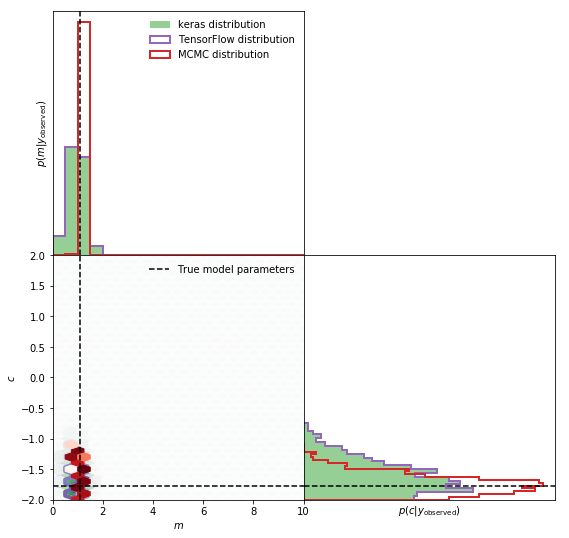

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
plt.subplots_adjust(wspace=0,hspace=0)
ax[0, 0].hist(keras_keep[:, 0], 
              bins=20, 
              range=[0, 10], 
              density=True, 
              color="C2", 
              alpha=0.5,
              label="keras distribution")
ax[0, 0].hist(tensorflow_keep[:, 0],
              bins=20, 
              range=[0, 10], 
              density=True, 
              color="C4", 
              linewidth=2, 
              histtype="step",
              label="TensorFlow distribution")
ax[0, 0].hist(chain[ind:, 2],
              weights=chain[ind:,0],
              bins=20, 
              range=[0, 10], 
              density=True, 
              color="C3", 
              linewidth=2, 
              histtype="step",
              label="MCMC distribution")
ax[0, 0].legend(frameon=False)
ax[0, 0].set_ylabel("$p(m|y_{\\rm observed})$")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 0].set_xlim([0, 10])
ax[0, 0].axvline(m_observed, 
                 color="black", 
                 linestyle="dashed")
ax[1, 0].hexbin(keras_keep[:, 0], 
                keras_keep[:, 1], 
                gridsize=(20, 20), 
                extent=(0, 10, -2, 2),
                cmap=plt.cm.Greens)
ax[1, 0].hexbin(tensorflow_keep[:, 0], 
                tensorflow_keep[:, 1], 
                gridsize=(20, 20), 
                extent=(0, 10, -2, 2),
                cmap=plt.cm.Purples,
                facecolor="none",
                linewidth=4)
ax[1, 0].hexbin(chain[ind:, 2],
                chain[ind:, 3],
                C=chain[ind:, 0], 
                gridsize=(20, 20), 
                extent=(0, 10, -2, 2),
                cmap=plt.cm.Reds)
ax[1, 0].axvline(m_observed, 
                 color="black", 
                 linestyle="dashed", 
                 label="True model parameters")
ax[1, 0].axhline(c_observed, 
                 color="black", 
                 linestyle="dashed")
ax[1, 0].legend(frameon=False)
ax[1, 0].set_xlim([0, 10])
ax[1, 0].set_ylim([-2, 2])
ax[1, 0].set_xlabel("$m$")
ax[1, 0].set_ylabel("$c$")
ax[0, 1].axis("off")
ax[1 ,1].set_ylim([-2, 2])
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 1].hist(keras_keep[:, 1],
              bins=20, 
              density=True, 
              color="C2", 
              alpha=0.5, 
              orientation="horizontal")
ax[1, 1].hist(tensorflow_keep[:, 1],
              bins=20, 
              density=True, 
              color="C4", 
              orientation="horizontal",
              linewidth=2, 
              histtype="step",)
ax[1, 1].hist(chain[ind:, 3],
              weights=chain[ind:, 0],
              bins=20, 
              density=True, 
              color="C3", 
              orientation="horizontal",
              linewidth=2, 
              histtype="step",)
ax[1, 1].set_xlabel("$p(c|y_{\\rm observed})$")
ax[1, 1].axhline(c_observed,
                 color="black", 
                 linestyle="dashed");

The distributions aren't the same, but LFI distributions are compatible (have wider variance than the MCMC), this is guaranteed to be true, i.e. there won't be zero probabality with the LFI distribution where there is positive probability from the MCMC posterior. Note that the LFI isn't supposed to be an approximation of the posterior, it is the posterior given some summaries (rather than the full data). The fact that these distributions have greater variance means that the networks are losing some information. It might be worth trying the IMNN (github.com/tomcharnock/IMNN.git) and pydelfi (github.com/justinalsing/pydelfi.git).